# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 21:08 - loss: 0.6951

  22/1875 [..............................] - ETA: 4s - loss: 0.5848   

  45/1875 [..............................] - ETA: 4s - loss: 0.5007

  68/1875 [>.............................] - ETA: 4s - loss: 0.4536

  93/1875 [>.............................] - ETA: 3s - loss: 0.4213

 117/1875 [>.............................] - ETA: 3s - loss: 0.3995

 141/1875 [=>............................] - ETA: 3s - loss: 0.3827

 166/1875 [=>............................] - ETA: 3s - loss: 0.3687

 191/1875 [==>...........................] - ETA: 3s - loss: 0.3570

 216/1875 [==>...........................] - ETA: 3s - loss: 0.3470

 240/1875 [==>...........................] - ETA: 3s - loss: 0.3385

 265/1875 [===>..........................] - ETA: 3s - loss: 0.3307

 290/1875 [===>..........................] - ETA: 3s - loss: 0.3237

 315/1875 [====>.........................] - ETA: 3s - loss: 0.3174

 338/1875 [====>.........................] - ETA: 3s - loss: 0.3120

 361/1875 [====>.........................] - ETA: 3s - loss: 0.3071

 378/1875 [=====>........................] - ETA: 3s - loss: 0.3037

 400/1875 [=====>........................] - ETA: 3s - loss: 0.2996

 419/1875 [=====>........................] - ETA: 3s - loss: 0.2962

 443/1875 [======>.......................] - ETA: 3s - loss: 0.2922

 465/1875 [======>.......................] - ETA: 3s - loss: 0.2888

 487/1875 [======>.......................] - ETA: 3s - loss: 0.2855

 511/1875 [=======>......................] - ETA: 3s - loss: 0.2821

 534/1875 [=======>......................] - ETA: 2s - loss: 0.2790

 558/1875 [=======>......................] - ETA: 2s - loss: 0.2760

 581/1875 [========>.....................] - ETA: 2s - loss: 0.2732

 607/1875 [========>.....................] - ETA: 2s - loss: 0.2703

 630/1875 [=========>....................] - ETA: 2s - loss: 0.2678

 657/1875 [=========>....................] - ETA: 2s - loss: 0.2650

 679/1875 [=========>....................] - ETA: 2s - loss: 0.2628

 700/1875 [==========>...................] - ETA: 2s - loss: 0.2608

 726/1875 [==========>...................] - ETA: 2s - loss: 0.2584

 752/1875 [===========>..................] - ETA: 2s - loss: 0.2561

 775/1875 [===========>..................] - ETA: 2s - loss: 0.2541

 801/1875 [===========>..................] - ETA: 2s - loss: 0.2520

 824/1875 [============>.................] - ETA: 2s - loss: 0.2502

 848/1875 [============>.................] - ETA: 2s - loss: 0.2484

 872/1875 [============>.................] - ETA: 2s - loss: 0.2466

 897/1875 [=============>................] - ETA: 2s - loss: 0.2448

 921/1875 [=============>................] - ETA: 2s - loss: 0.2432

 944/1875 [==============>...............] - ETA: 2s - loss: 0.2417

 969/1875 [==============>...............] - ETA: 1s - loss: 0.2400

 990/1875 [==============>...............] - ETA: 1s - loss: 0.2387

1008/1875 [===============>..............] - ETA: 1s - loss: 0.2376

1028/1875 [===============>..............] - ETA: 1s - loss: 0.2364

1053/1875 [===============>..............] - ETA: 1s - loss: 0.2350

1078/1875 [================>.............] - ETA: 1s - loss: 0.2336

1103/1875 [================>.............] - ETA: 1s - loss: 0.2322

1128/1875 [=================>............] - ETA: 1s - loss: 0.2308

1153/1875 [=================>............] - ETA: 1s - loss: 0.2295

1177/1875 [=================>............] - ETA: 1s - loss: 0.2283

1202/1875 [==================>...........] - ETA: 1s - loss: 0.2271

1228/1875 [==================>...........] - ETA: 1s - loss: 0.2258

1250/1875 [===================>..........] - ETA: 1s - loss: 0.2248

1276/1875 [===================>..........] - ETA: 1s - loss: 0.2236

1295/1875 [===================>..........] - ETA: 1s - loss: 0.2227

1320/1875 [====================>.........] - ETA: 1s - loss: 0.2216

1344/1875 [====================>.........] - ETA: 1s - loss: 0.2206

1370/1875 [====================>.........] - ETA: 1s - loss: 0.2195

1396/1875 [=====================>........] - ETA: 1s - loss: 0.2185

1422/1875 [=====================>........] - ETA: 0s - loss: 0.2174

1448/1875 [======================>.......] - ETA: 0s - loss: 0.2164

1474/1875 [======================>.......] - ETA: 0s - loss: 0.2154

1500/1875 [=======================>......] - ETA: 0s - loss: 0.2144

1524/1875 [=======================>......] - ETA: 0s - loss: 0.2135

1546/1875 [=======================>......] - ETA: 0s - loss: 0.2127

1572/1875 [========================>.....] - ETA: 0s - loss: 0.2118

1598/1875 [========================>.....] - ETA: 0s - loss: 0.2109

1624/1875 [========================>.....] - ETA: 0s - loss: 0.2100

1650/1875 [=========================>....] - ETA: 0s - loss: 0.2092

1675/1875 [=========================>....] - ETA: 0s - loss: 0.2084

1701/1875 [==========================>...] - ETA: 0s - loss: 0.2075

1723/1875 [==========================>...] - ETA: 0s - loss: 0.2068

1745/1875 [==========================>...] - ETA: 0s - loss: 0.2062

1767/1875 [===========================>..] - ETA: 0s - loss: 0.2055

1793/1875 [===========================>..] - ETA: 0s - loss: 0.2047

1817/1875 [============================>.] - ETA: 0s - loss: 0.2040

1843/1875 [============================>.] - ETA: 0s - loss: 0.2033

1868/1875 [============================>.] - ETA: 0s - loss: 0.2026

1875/1875 [==============================] - 5s 2ms/step - loss: 0.2023


Epoch 2/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1143

  25/1875 [..............................] - ETA: 4s - loss: 0.1089

  48/1875 [..............................] - ETA: 4s - loss: 0.1088

  72/1875 [>.............................] - ETA: 4s - loss: 0.1087

  85/1875 [>.............................] - ETA: 4s - loss: 0.1086

 109/1875 [>.............................] - ETA: 4s - loss: 0.1086

 130/1875 [=>............................] - ETA: 4s - loss: 0.1086

 151/1875 [=>............................] - ETA: 4s - loss: 0.1086

 174/1875 [=>............................] - ETA: 4s - loss: 0.1086

 200/1875 [==>...........................] - ETA: 3s - loss: 0.1086

 222/1875 [==>...........................] - ETA: 3s - loss: 0.1086

 243/1875 [==>...........................] - ETA: 3s - loss: 0.1086

 263/1875 [===>..........................] - ETA: 3s - loss: 0.1085

 284/1875 [===>..........................] - ETA: 3s - loss: 0.1085

 306/1875 [===>..........................] - ETA: 3s - loss: 0.1084

 330/1875 [====>.........................] - ETA: 3s - loss: 0.1084

 353/1875 [====>.........................] - ETA: 3s - loss: 0.1083

 373/1875 [====>.........................] - ETA: 3s - loss: 0.1083

 397/1875 [=====>........................] - ETA: 3s - loss: 0.1083

 416/1875 [=====>........................] - ETA: 3s - loss: 0.1083

 438/1875 [======>.......................] - ETA: 3s - loss: 0.1082

 460/1875 [======>.......................] - ETA: 3s - loss: 0.1082

 486/1875 [======>.......................] - ETA: 3s - loss: 0.1082

 510/1875 [=======>......................] - ETA: 3s - loss: 0.1081

 536/1875 [=======>......................] - ETA: 3s - loss: 0.1081

 560/1875 [=======>......................] - ETA: 3s - loss: 0.1080

 583/1875 [========>.....................] - ETA: 2s - loss: 0.1080

 609/1875 [========>.....................] - ETA: 2s - loss: 0.1079

 632/1875 [=========>....................] - ETA: 2s - loss: 0.1079

 657/1875 [=========>....................] - ETA: 2s - loss: 0.1079

 683/1875 [=========>....................] - ETA: 2s - loss: 0.1078

 709/1875 [==========>...................] - ETA: 2s - loss: 0.1078

 735/1875 [==========>...................] - ETA: 2s - loss: 0.1077

 761/1875 [===========>..................] - ETA: 2s - loss: 0.1077

 787/1875 [===========>..................] - ETA: 2s - loss: 0.1076

 814/1875 [============>.................] - ETA: 2s - loss: 0.1076

 840/1875 [============>.................] - ETA: 2s - loss: 0.1075

 866/1875 [============>.................] - ETA: 2s - loss: 0.1075

 891/1875 [=============>................] - ETA: 2s - loss: 0.1074

 915/1875 [=============>................] - ETA: 2s - loss: 0.1074

 939/1875 [==============>...............] - ETA: 2s - loss: 0.1073

 965/1875 [==============>...............] - ETA: 1s - loss: 0.1073

 990/1875 [==============>...............] - ETA: 1s - loss: 0.1072

1015/1875 [===============>..............] - ETA: 1s - loss: 0.1072

1041/1875 [===============>..............] - ETA: 1s - loss: 0.1071

1065/1875 [================>.............] - ETA: 1s - loss: 0.1071

1091/1875 [================>.............] - ETA: 1s - loss: 0.1070

1113/1875 [================>.............] - ETA: 1s - loss: 0.1070

1139/1875 [=================>............] - ETA: 1s - loss: 0.1070

1165/1875 [=================>............] - ETA: 1s - loss: 0.1069

1190/1875 [==================>...........] - ETA: 1s - loss: 0.1069

1215/1875 [==================>...........] - ETA: 1s - loss: 0.1068

1241/1875 [==================>...........] - ETA: 1s - loss: 0.1068

1266/1875 [===================>..........] - ETA: 1s - loss: 0.1067

1292/1875 [===================>..........] - ETA: 1s - loss: 0.1067

1317/1875 [====================>.........] - ETA: 1s - loss: 0.1066

1342/1875 [====================>.........] - ETA: 1s - loss: 0.1066

1367/1875 [====================>.........] - ETA: 1s - loss: 0.1065

1393/1875 [=====================>........] - ETA: 1s - loss: 0.1065

1419/1875 [=====================>........] - ETA: 0s - loss: 0.1064

1445/1875 [======================>.......] - ETA: 0s - loss: 0.1064

1472/1875 [======================>.......] - ETA: 0s - loss: 0.1063

1495/1875 [======================>.......] - ETA: 0s - loss: 0.1063

1521/1875 [=======================>......] - ETA: 0s - loss: 0.1063

1546/1875 [=======================>......] - ETA: 0s - loss: 0.1062

1570/1875 [========================>.....] - ETA: 0s - loss: 0.1062

1596/1875 [========================>.....] - ETA: 0s - loss: 0.1061

1618/1875 [========================>.....] - ETA: 0s - loss: 0.1061

1638/1875 [=========================>....] - ETA: 0s - loss: 0.1061

1657/1875 [=========================>....] - ETA: 0s - loss: 0.1060

1680/1875 [=========================>....] - ETA: 0s - loss: 0.1060

1706/1875 [==========================>...] - ETA: 0s - loss: 0.1059

1731/1875 [==========================>...] - ETA: 0s - loss: 0.1059

1754/1875 [===========================>..] - ETA: 0s - loss: 0.1059

1776/1875 [===========================>..] - ETA: 0s - loss: 0.1058

1798/1875 [===========================>..] - ETA: 0s - loss: 0.1058

1822/1875 [============================>.] - ETA: 0s - loss: 0.1058

1845/1875 [============================>.] - ETA: 0s - loss: 0.1057

1866/1875 [============================>.] - ETA: 0s - loss: 0.1057

1875/1875 [==============================] - 4s 2ms/step - loss: 0.1057


Epoch 3/5
   1/1875 [..............................] - ETA: 5s - loss: 0.1046

  21/1875 [..............................] - ETA: 4s - loss: 0.0987

  46/1875 [..............................] - ETA: 4s - loss: 0.0981

  71/1875 [>.............................] - ETA: 4s - loss: 0.0981

  92/1875 [>.............................] - ETA: 4s - loss: 0.0981

 111/1875 [>.............................] - ETA: 4s - loss: 0.0981

 133/1875 [=>............................] - ETA: 4s - loss: 0.0980

 158/1875 [=>............................] - ETA: 3s - loss: 0.0980

 179/1875 [=>............................] - ETA: 3s - loss: 0.0980

 199/1875 [==>...........................] - ETA: 3s - loss: 0.0979

 222/1875 [==>...........................] - ETA: 3s - loss: 0.0979

 238/1875 [==>...........................] - ETA: 3s - loss: 0.0978

 263/1875 [===>..........................] - ETA: 3s - loss: 0.0978

 288/1875 [===>..........................] - ETA: 3s - loss: 0.0978

 313/1875 [====>.........................] - ETA: 3s - loss: 0.0978

 339/1875 [====>.........................] - ETA: 3s - loss: 0.0978

 366/1875 [====>.........................] - ETA: 3s - loss: 0.0978

 388/1875 [=====>........................] - ETA: 3s - loss: 0.0978

 414/1875 [=====>........................] - ETA: 3s - loss: 0.0978

 438/1875 [======>.......................] - ETA: 3s - loss: 0.0978

 464/1875 [======>.......................] - ETA: 3s - loss: 0.0978

 490/1875 [======>.......................] - ETA: 3s - loss: 0.0978

 515/1875 [=======>......................] - ETA: 2s - loss: 0.0978

 541/1875 [=======>......................] - ETA: 2s - loss: 0.0978

 566/1875 [========>.....................] - ETA: 2s - loss: 0.0978

 593/1875 [========>.....................] - ETA: 2s - loss: 0.0977

 619/1875 [========>.....................] - ETA: 2s - loss: 0.0977

 645/1875 [=========>....................] - ETA: 2s - loss: 0.0977

 671/1875 [=========>....................] - ETA: 2s - loss: 0.0977

 697/1875 [==========>...................] - ETA: 2s - loss: 0.0977

 721/1875 [==========>...................] - ETA: 2s - loss: 0.0977

 743/1875 [==========>...................] - ETA: 2s - loss: 0.0977

 767/1875 [===========>..................] - ETA: 2s - loss: 0.0977

 785/1875 [===========>..................] - ETA: 2s - loss: 0.0977

 807/1875 [===========>..................] - ETA: 2s - loss: 0.0977

 826/1875 [============>.................] - ETA: 2s - loss: 0.0977

 848/1875 [============>.................] - ETA: 2s - loss: 0.0977

 873/1875 [============>.................] - ETA: 2s - loss: 0.0977

 900/1875 [=============>................] - ETA: 2s - loss: 0.0977

 918/1875 [=============>................] - ETA: 2s - loss: 0.0977

 940/1875 [==============>...............] - ETA: 2s - loss: 0.0976

 961/1875 [==============>...............] - ETA: 1s - loss: 0.0976

 981/1875 [==============>...............] - ETA: 1s - loss: 0.0976

1000/1875 [===============>..............] - ETA: 1s - loss: 0.0976

1023/1875 [===============>..............] - ETA: 1s - loss: 0.0976

1047/1875 [===============>..............] - ETA: 1s - loss: 0.0976

1074/1875 [================>.............] - ETA: 1s - loss: 0.0976

1098/1875 [================>.............] - ETA: 1s - loss: 0.0976

1124/1875 [================>.............] - ETA: 1s - loss: 0.0976

1148/1875 [=================>............] - ETA: 1s - loss: 0.0976

1174/1875 [=================>............] - ETA: 1s - loss: 0.0976

1200/1875 [==================>...........] - ETA: 1s - loss: 0.0976

1224/1875 [==================>...........] - ETA: 1s - loss: 0.0976

1250/1875 [===================>..........] - ETA: 1s - loss: 0.0976

1275/1875 [===================>..........] - ETA: 1s - loss: 0.0976

1301/1875 [===================>..........] - ETA: 1s - loss: 0.0976

1322/1875 [====================>.........] - ETA: 1s - loss: 0.0976

1348/1875 [====================>.........] - ETA: 1s - loss: 0.0976

1372/1875 [====================>.........] - ETA: 1s - loss: 0.0975

1397/1875 [=====================>........] - ETA: 1s - loss: 0.0975

1420/1875 [=====================>........] - ETA: 0s - loss: 0.0975

1445/1875 [======================>.......] - ETA: 0s - loss: 0.0975

1470/1875 [======================>.......] - ETA: 0s - loss: 0.0975

1495/1875 [======================>.......] - ETA: 0s - loss: 0.0975

1520/1875 [=======================>......] - ETA: 0s - loss: 0.0975

1545/1875 [=======================>......] - ETA: 0s - loss: 0.0975

1570/1875 [========================>.....] - ETA: 0s - loss: 0.0975

1595/1875 [========================>.....] - ETA: 0s - loss: 0.0975

1621/1875 [========================>.....] - ETA: 0s - loss: 0.0975

1646/1875 [=========================>....] - ETA: 0s - loss: 0.0975

1671/1875 [=========================>....] - ETA: 0s - loss: 0.0975

1692/1875 [==========================>...] - ETA: 0s - loss: 0.0975

1717/1875 [==========================>...] - ETA: 0s - loss: 0.0975

1741/1875 [==========================>...] - ETA: 0s - loss: 0.0975

1765/1875 [===========================>..] - ETA: 0s - loss: 0.0974

1789/1875 [===========================>..] - ETA: 0s - loss: 0.0974

1814/1875 [============================>.] - ETA: 0s - loss: 0.0974

1835/1875 [============================>.] - ETA: 0s - loss: 0.0974

1860/1875 [============================>.] - ETA: 0s - loss: 0.0974

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0974


Epoch 4/5
   1/1875 [..............................] - ETA: 4s - loss: 0.0979

  26/1875 [..............................] - ETA: 3s - loss: 0.1005

  48/1875 [..............................] - ETA: 4s - loss: 0.0990

  68/1875 [>.............................] - ETA: 4s - loss: 0.0985

  92/1875 [>.............................] - ETA: 4s - loss: 0.0980

 117/1875 [>.............................] - ETA: 3s - loss: 0.0977

 139/1875 [=>............................] - ETA: 3s - loss: 0.0974

 163/1875 [=>............................] - ETA: 3s - loss: 0.0973

 182/1875 [=>............................] - ETA: 3s - loss: 0.0972

 205/1875 [==>...........................] - ETA: 3s - loss: 0.0971

 225/1875 [==>...........................] - ETA: 3s - loss: 0.0970

 249/1875 [==>...........................] - ETA: 3s - loss: 0.0969

 269/1875 [===>..........................] - ETA: 3s - loss: 0.0969

 289/1875 [===>..........................] - ETA: 3s - loss: 0.0968

 311/1875 [===>..........................] - ETA: 3s - loss: 0.0968

 339/1875 [====>.........................] - ETA: 3s - loss: 0.0967

 362/1875 [====>.........................] - ETA: 3s - loss: 0.0967

 389/1875 [=====>........................] - ETA: 3s - loss: 0.0966

 410/1875 [=====>........................] - ETA: 3s - loss: 0.0966

 436/1875 [=====>........................] - ETA: 3s - loss: 0.0965

 462/1875 [======>.......................] - ETA: 3s - loss: 0.0965

 488/1875 [======>.......................] - ETA: 3s - loss: 0.0965

 514/1875 [=======>......................] - ETA: 2s - loss: 0.0964

 540/1875 [=======>......................] - ETA: 2s - loss: 0.0964

 565/1875 [========>.....................] - ETA: 2s - loss: 0.0964

 592/1875 [========>.....................] - ETA: 2s - loss: 0.0964

 616/1875 [========>.....................] - ETA: 2s - loss: 0.0964

 643/1875 [=========>....................] - ETA: 2s - loss: 0.0963

 667/1875 [=========>....................] - ETA: 2s - loss: 0.0963

 687/1875 [=========>....................] - ETA: 2s - loss: 0.0963

 700/1875 [==========>...................] - ETA: 2s - loss: 0.0963

 720/1875 [==========>...................] - ETA: 2s - loss: 0.0963

 741/1875 [==========>...................] - ETA: 2s - loss: 0.0963

 760/1875 [===========>..................] - ETA: 2s - loss: 0.0963

 780/1875 [===========>..................] - ETA: 2s - loss: 0.0963

 801/1875 [===========>..................] - ETA: 2s - loss: 0.0962

 824/1875 [============>.................] - ETA: 2s - loss: 0.0962

 849/1875 [============>.................] - ETA: 2s - loss: 0.0962

 875/1875 [=============>................] - ETA: 2s - loss: 0.0962

 899/1875 [=============>................] - ETA: 2s - loss: 0.0962

 922/1875 [=============>................] - ETA: 2s - loss: 0.0962

 945/1875 [==============>...............] - ETA: 2s - loss: 0.0962

 967/1875 [==============>...............] - ETA: 2s - loss: 0.0962

 991/1875 [==============>...............] - ETA: 1s - loss: 0.0962

1016/1875 [===============>..............] - ETA: 1s - loss: 0.0962

1041/1875 [===============>..............] - ETA: 1s - loss: 0.0962

1067/1875 [================>.............] - ETA: 1s - loss: 0.0961

1093/1875 [================>.............] - ETA: 1s - loss: 0.0961

1110/1875 [================>.............] - ETA: 1s - loss: 0.0961

1134/1875 [=================>............] - ETA: 1s - loss: 0.0961

1153/1875 [=================>............] - ETA: 1s - loss: 0.0961

1171/1875 [=================>............] - ETA: 1s - loss: 0.0961

1196/1875 [==================>...........] - ETA: 1s - loss: 0.0961

1219/1875 [==================>...........] - ETA: 1s - loss: 0.0961

1237/1875 [==================>...........] - ETA: 1s - loss: 0.0961

1262/1875 [===================>..........] - ETA: 1s - loss: 0.0961

1286/1875 [===================>..........] - ETA: 1s - loss: 0.0961

1311/1875 [===================>..........] - ETA: 1s - loss: 0.0961

1335/1875 [====================>.........] - ETA: 1s - loss: 0.0961

1361/1875 [====================>.........] - ETA: 1s - loss: 0.0961

1382/1875 [=====================>........] - ETA: 1s - loss: 0.0961

1407/1875 [=====================>........] - ETA: 1s - loss: 0.0961

1431/1875 [=====================>........] - ETA: 0s - loss: 0.0961

1457/1875 [======================>.......] - ETA: 0s - loss: 0.0960

1483/1875 [======================>.......] - ETA: 0s - loss: 0.0960

1508/1875 [=======================>......] - ETA: 0s - loss: 0.0960

1533/1875 [=======================>......] - ETA: 0s - loss: 0.0960

1557/1875 [=======================>......] - ETA: 0s - loss: 0.0960

1575/1875 [========================>.....] - ETA: 0s - loss: 0.0960

1599/1875 [========================>.....] - ETA: 0s - loss: 0.0960

1617/1875 [========================>.....] - ETA: 0s - loss: 0.0960

1642/1875 [=========================>....] - ETA: 0s - loss: 0.0960

1661/1875 [=========================>....] - ETA: 0s - loss: 0.0960

1687/1875 [=========================>....] - ETA: 0s - loss: 0.0960

1713/1875 [==========================>...] - ETA: 0s - loss: 0.0960

1738/1875 [==========================>...] - ETA: 0s - loss: 0.0960

1765/1875 [===========================>..] - ETA: 0s - loss: 0.0960

1791/1875 [===========================>..] - ETA: 0s - loss: 0.0960

1815/1875 [============================>.] - ETA: 0s - loss: 0.0960

1841/1875 [============================>.] - ETA: 0s - loss: 0.0960

1864/1875 [============================>.] - ETA: 0s - loss: 0.0960

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0960


Epoch 5/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0900

  20/1875 [..............................] - ETA: 5s - loss: 0.0944

  39/1875 [..............................] - ETA: 4s - loss: 0.0945

  58/1875 [..............................] - ETA: 4s - loss: 0.0945

  83/1875 [>.............................] - ETA: 4s - loss: 0.0944

 106/1875 [>.............................] - ETA: 4s - loss: 0.0944

 131/1875 [=>............................] - ETA: 4s - loss: 0.0944

 157/1875 [=>............................] - ETA: 3s - loss: 0.0945

 181/1875 [=>............................] - ETA: 3s - loss: 0.0945

 207/1875 [==>...........................] - ETA: 3s - loss: 0.0945

 226/1875 [==>...........................] - ETA: 3s - loss: 0.0946

 247/1875 [==>...........................] - ETA: 3s - loss: 0.0946

 268/1875 [===>..........................] - ETA: 3s - loss: 0.0947

 292/1875 [===>..........................] - ETA: 3s - loss: 0.0947

 317/1875 [====>.........................] - ETA: 3s - loss: 0.0947

 340/1875 [====>.........................] - ETA: 3s - loss: 0.0947

 360/1875 [====>.........................] - ETA: 3s - loss: 0.0948

 385/1875 [=====>........................] - ETA: 3s - loss: 0.0948

 410/1875 [=====>........................] - ETA: 3s - loss: 0.0948

 435/1875 [=====>........................] - ETA: 3s - loss: 0.0948

 459/1875 [======>.......................] - ETA: 3s - loss: 0.0949

 484/1875 [======>.......................] - ETA: 3s - loss: 0.0949

 509/1875 [=======>......................] - ETA: 3s - loss: 0.0949

 534/1875 [=======>......................] - ETA: 2s - loss: 0.0949

 559/1875 [=======>......................] - ETA: 2s - loss: 0.0949

 584/1875 [========>.....................] - ETA: 2s - loss: 0.0950

 609/1875 [========>.....................] - ETA: 2s - loss: 0.0950

 634/1875 [=========>....................] - ETA: 2s - loss: 0.0950

 659/1875 [=========>....................] - ETA: 2s - loss: 0.0950

 684/1875 [=========>....................] - ETA: 2s - loss: 0.0950

 710/1875 [==========>...................] - ETA: 2s - loss: 0.0950

 733/1875 [==========>...................] - ETA: 2s - loss: 0.0950

 758/1875 [===========>..................] - ETA: 2s - loss: 0.0950

 782/1875 [===========>..................] - ETA: 2s - loss: 0.0950

 806/1875 [===========>..................] - ETA: 2s - loss: 0.0950

 830/1875 [============>.................] - ETA: 2s - loss: 0.0950

 854/1875 [============>.................] - ETA: 2s - loss: 0.0950

 878/1875 [=============>................] - ETA: 2s - loss: 0.0950

 903/1875 [=============>................] - ETA: 2s - loss: 0.0950

 928/1875 [=============>................] - ETA: 2s - loss: 0.0950

 952/1875 [==============>...............] - ETA: 1s - loss: 0.0950

 977/1875 [==============>...............] - ETA: 1s - loss: 0.0950

1002/1875 [===============>..............] - ETA: 1s - loss: 0.0950

1027/1875 [===============>..............] - ETA: 1s - loss: 0.0950

1052/1875 [===============>..............] - ETA: 1s - loss: 0.0950

1078/1875 [================>.............] - ETA: 1s - loss: 0.0950

1103/1875 [================>.............] - ETA: 1s - loss: 0.0950

1123/1875 [================>.............] - ETA: 1s - loss: 0.0950

1144/1875 [=================>............] - ETA: 1s - loss: 0.0950

1165/1875 [=================>............] - ETA: 1s - loss: 0.0950

1188/1875 [==================>...........] - ETA: 1s - loss: 0.0950

1211/1875 [==================>...........] - ETA: 1s - loss: 0.0950

1233/1875 [==================>...........] - ETA: 1s - loss: 0.0950

1258/1875 [===================>..........] - ETA: 1s - loss: 0.0950

1280/1875 [===================>..........] - ETA: 1s - loss: 0.0950

1303/1875 [===================>..........] - ETA: 1s - loss: 0.0950

1321/1875 [====================>.........] - ETA: 1s - loss: 0.0950

1346/1875 [====================>.........] - ETA: 1s - loss: 0.0950

1371/1875 [====================>.........] - ETA: 1s - loss: 0.0950

1395/1875 [=====================>........] - ETA: 1s - loss: 0.0950

1420/1875 [=====================>........] - ETA: 0s - loss: 0.0950

1445/1875 [======================>.......] - ETA: 0s - loss: 0.0950

1471/1875 [======================>.......] - ETA: 0s - loss: 0.0950

1496/1875 [======================>.......] - ETA: 0s - loss: 0.0950

1522/1875 [=======================>......] - ETA: 0s - loss: 0.0950

1546/1875 [=======================>......] - ETA: 0s - loss: 0.0950

1573/1875 [========================>.....] - ETA: 0s - loss: 0.0950

1593/1875 [========================>.....] - ETA: 0s - loss: 0.0950

1618/1875 [========================>.....] - ETA: 0s - loss: 0.0950

1643/1875 [=========================>....] - ETA: 0s - loss: 0.0950

1668/1875 [=========================>....] - ETA: 0s - loss: 0.0950

1694/1875 [==========================>...] - ETA: 0s - loss: 0.0950

1719/1875 [==========================>...] - ETA: 0s - loss: 0.0950

1744/1875 [==========================>...] - ETA: 0s - loss: 0.0950

1770/1875 [===========================>..] - ETA: 0s - loss: 0.0950

1793/1875 [===========================>..] - ETA: 0s - loss: 0.0950

1819/1875 [============================>.] - ETA: 0s - loss: 0.0950

1846/1875 [============================>.] - ETA: 0s - loss: 0.0950

1871/1875 [============================>.] - ETA: 0s - loss: 0.0950

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0950


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

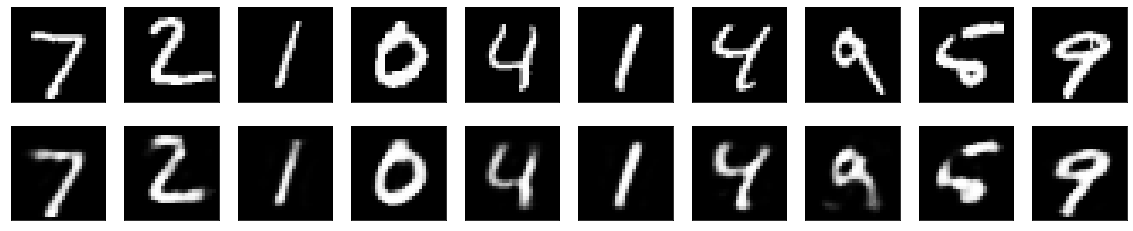

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
